In [1]:
import pyro
import torch
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import ExitStack
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

from causal_pyro.dynamical.handlers import (
    PointObservation,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)
from causal_pyro.dynamical.ops import State, Trajectory

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

In [2]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        S = pyro.deterministic("S", X.S)
        I = pyro.deterministic("I", X.I)
        R = pyro.deterministic("R", X.R)
        test_kit_sales = torch.relu(pyro.sample("test_kit_sales", dist.Normal(torch.log(X.S + 1), 1)))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs, "S": S, "I": I, "R": R}

# Generate synthetic data from an SIR model

In [3]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.))
time_period = torch.linspace(0, 3, steps=21)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true =  torch.tensor(0.5)
sir = SimpleSIRDynamics(beta_true, gamma_true)
sir_traj = simulate(sir, init_state, time_period)

### Plot the simulated trajectories from SIR model

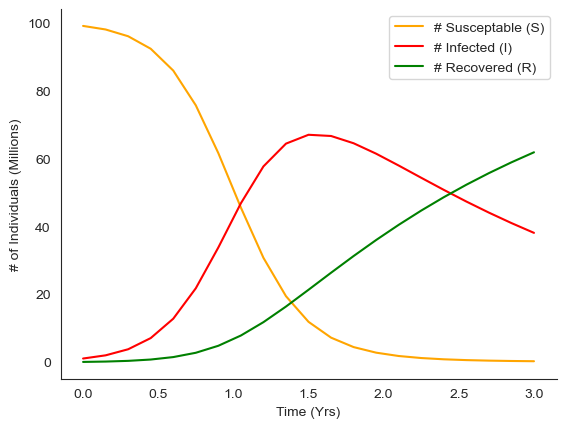

In [4]:
sns.lineplot(x=time_period, y=sir_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_traj.R, label="# Recovered (R)", color='green')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Sample observed data from the model
 

In [5]:
obs_time_period = torch.arange(0, 1.01, 1/52) # collect data every week for the past 1yr
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir, init_state, obs_time_period)
data = dict()
for time_ix in range(N_obs):
    data[time_ix] = [obs_time_period[time_ix], sir.observation(sir_obs_traj[time_ix])]

In [6]:
test_kit_sales = torch.stack([data[time_ix][1]["test_kit_sales"] for time_ix in range(N_obs)])
I_obs = torch.stack([data[time_ix][1]["I_obs"] for time_ix in range(N_obs)])
R_obs = torch.stack([data[time_ix][1]["R_obs"] for time_ix in range(N_obs)])

Text(0, 0.5, 'Observed # Recovered (Millions)')

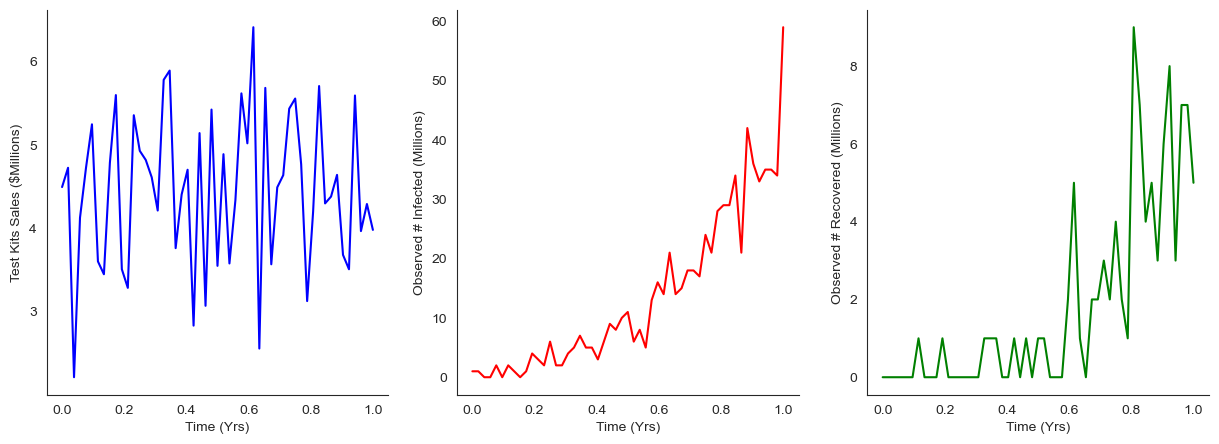

In [7]:
# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.lineplot(x=obs_time_period, y=test_kit_sales, color='blue', ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

# Perform Inference!

In [12]:
# We place uniform priors on the beta and gamma parameters defining the SIR model 
def model():
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = SimpleSIRDynamics(beta, gamma)
    return sir


def unconditional_sir_model(data, init_state, tspan):
    sir = model()
    return simulate(sir, init_state, tspan)


def conditioned_sir(data, init_state, tspan):
    sir = model()
    observation_managers = []
    for obs in data.values():
        obs_time = obs[0].item()
        obs_data = obs[1]
        observation_managers.append(PointObservation(obs_time, obs_data))
    with SimulatorEventLoop():
        with ExitStack() as stack:
            for manager in observation_managers:
                stack.enter_context(manager)
            traj = simulate(sir, init_state, tspan)
    return traj

In [9]:
guide = AutoMultivariateNormal(conditioned_sir)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(conditioned_sir, guide, adam, loss=Trace_ELBO())
n_steps = 200

# Do gradient steps
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(data, init_state, torch.tensor([0., 3.])) # need tspan to contain all observation times
    print("[iteration %04d] loss: %.4f" % (step + 1, loss / N_obs))
    guide_median = guide.median()
    print("beta post. median est: %.4f, gamma post. median est: %.4f" % (guide_median['beta'].item(), guide_median['gamma'].item()))
        

[iteration 0001] loss: 66.6493
beta post. median est: 0.4665, gamma post. median est: 0.4076
[iteration 0002] loss: 66.4320
beta post. median est: 0.4590, gamma post. median est: 0.4004
[iteration 0003] loss: 65.9829
beta post. median est: 0.4516, gamma post. median est: 0.3933
[iteration 0004] loss: 65.9836
beta post. median est: 0.4441, gamma post. median est: 0.3862
[iteration 0005] loss: 65.4919
beta post. median est: 0.4367, gamma post. median est: 0.3792
[iteration 0006] loss: 65.8017
beta post. median est: 0.4293, gamma post. median est: 0.3723
[iteration 0007] loss: 65.6872
beta post. median est: 0.4219, gamma post. median est: 0.3654
[iteration 0008] loss: 65.6913
beta post. median est: 0.4145, gamma post. median est: 0.3587
[iteration 0009] loss: 64.8473
beta post. median est: 0.4072, gamma post. median est: 0.3519
[iteration 0010] loss: 62.6847
beta post. median est: 0.3998, gamma post. median est: 0.3454
[iteration 0011] loss: 64.3448
beta post. median est: 0.3924, gamma po

# Evaluate the performance of our inference

In [20]:
# Generate samples from the posterior predictive distribution
predictive = Predictive(unconditional_sir_model, guide=guide, num_samples=100)
samples = predictive(data, init_state, torch.tensor([0., .01])) # just trying to get beta and gamma samples

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

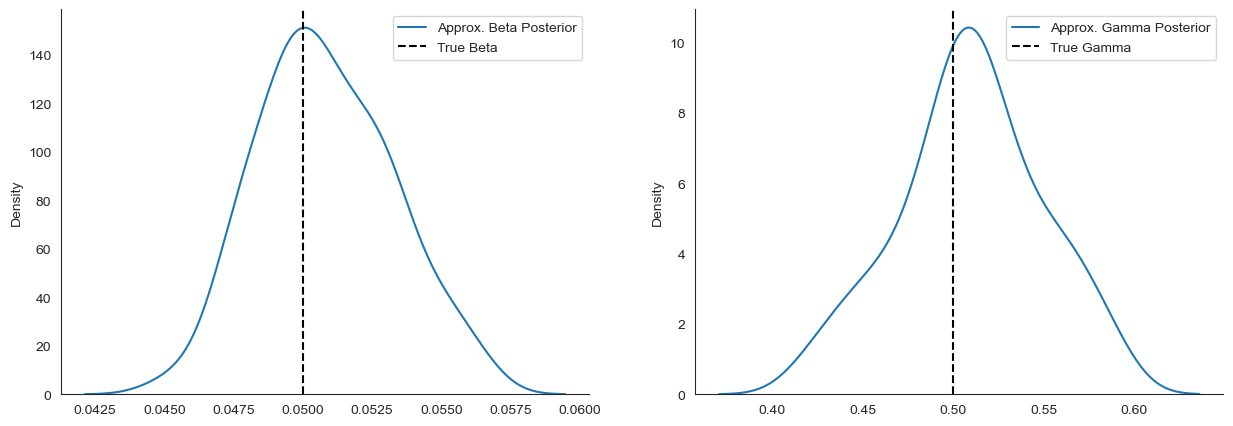

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(samples['beta'], label='Approx. Beta Posterior', ax=ax[0])
ax[0].axvline(beta_true, color='black', label='True Beta', linestyle='--')
sns.despine()
ax[0].legend(loc='upper right')

sns.kdeplot(samples['gamma'], label='Approx. Gamma Posterior', ax=ax[1])
plt.axvline(gamma_true, color='black', label='True Gamma', linestyle='--')
sns.despine()
ax[1].legend(loc='upper right')

### Next, we compare the predictive performance on the held at period between $t=1$ and $t=3$ years

In [23]:
# TODO: we should add functionality so that pyro Predictive gives use predictions of sites in `observation` method...
 
S_pred = []
I_pred = []
R_pred = []

for beta, gamma in zip(samples['beta'], samples['gamma']):
    sir = SimpleSIRDynamics(beta, gamma)
    sir_traj = simulate(sir, init_state, time_period)
    S_pred.append(sir_traj.S)
    I_pred.append(sir_traj.I)
    R_pred.append(sir_traj.R)
    

In [128]:
### TODO: we should make it easier to get predictions at observation times...approach below is very hacky

# Get predicted values for S, I, and R
S_keys = sorted([key for key in samples.keys() if 'S_' in key], key=lambda x: float(x.split("_")[1]))
I_keys = sorted([key for key in samples.keys() if ('I_' in key) and ('obs' not in key)], key=lambda x: float(x.split("_")[1]))
R_keys = sorted([key for key in samples.keys() if ('R_' in key) and ('obs' not in key)], key=lambda x: float(x.split("_")[1]))

S_pred = torch.stack([samples[key] for key in S_keys])
I_pred = torch.stack([samples[key] for key in I_keys])
R_pred = torch.stack([samples[key] for key in R_keys])

time_points = torch.tensor([float(key.split("_")[1]) for key in S_keys])

In [145]:
samples['beta']

tensor([0.0495, 0.0542, 0.0478, 0.0486, 0.0511, 0.0506, 0.0521, 0.0527, 0.0483,
        0.0506, 0.0463, 0.0515, 0.0532, 0.0498, 0.0492, 0.0513, 0.0498, 0.0505,
        0.0498, 0.0512, 0.0456, 0.0485, 0.0486, 0.0494, 0.0485, 0.0516, 0.0509,
        0.0541, 0.0507, 0.0520, 0.0507, 0.0486, 0.0522, 0.0467, 0.0512, 0.0504,
        0.0489, 0.0535, 0.0486, 0.0515, 0.0496, 0.0524, 0.0509, 0.0479, 0.0479,
        0.0511, 0.0480, 0.0473, 0.0484, 0.0483, 0.0506, 0.0508, 0.0487, 0.0504,
        0.0508, 0.0527, 0.0527, 0.0502, 0.0510, 0.0510, 0.0487, 0.0486, 0.0507,
        0.0497, 0.0517, 0.0517, 0.0473, 0.0483, 0.0503, 0.0489, 0.0475, 0.0477,
        0.0501, 0.0519, 0.0512, 0.0524, 0.0520, 0.0511, 0.0493, 0.0495, 0.0487,
        0.0490, 0.0484, 0.0502, 0.0494, 0.0537, 0.0471, 0.0502, 0.0489, 0.0499,
        0.0492, 0.0495, 0.0500, 0.0513, 0.0496, 0.0496, 0.0488, 0.0484, 0.0515,
        0.0527])

In [144]:
samples['test_kit_sales_0.01923177018761635']

tensor([4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245, 4.7245,
        4.7245])

Predictive(conditioned_sir, guide=guide, num_samples=100)

In [ ]:
predictive(data, init_state, time_period)

In [161]:
sir_samp = SimpleSIRDynamics(torch.tensor(0.0515), torch.tensor(0.5100))
ex_traj = simulate(sir_samp, init_state, time_points)

In [164]:
time_points

tensor([1.0000e-06, 1.9232e-02, 3.8463e-02, 5.7693e-02, 7.6924e-02, 9.6155e-02,
        1.1539e-01, 1.3462e-01, 1.5385e-01, 1.7308e-01, 1.9231e-01, 2.1154e-01,
        2.3077e-01, 2.5000e-01, 2.6923e-01, 2.8846e-01, 3.0769e-01, 3.2692e-01,
        3.4615e-01, 3.6539e-01, 3.8462e-01, 4.0385e-01, 4.2308e-01, 4.4231e-01,
        4.6154e-01, 4.8077e-01, 5.0000e-01, 5.1923e-01, 5.3846e-01, 5.5769e-01,
        5.7692e-01, 5.9615e-01, 6.1539e-01, 6.3462e-01, 6.5385e-01, 6.7308e-01,
        6.9231e-01, 7.1154e-01, 7.3077e-01, 7.5000e-01, 7.6923e-01, 7.8846e-01,
        8.0769e-01, 8.2692e-01, 8.4615e-01, 8.6539e-01, 8.8462e-01, 9.0385e-01,
        9.2308e-01, 9.4231e-01, 9.6154e-01, 9.8077e-01, 1.0000e+00, 1.0192e+00,
        1.0385e+00, 1.0577e+00, 1.0769e+00, 1.0962e+00, 1.1154e+00, 1.1346e+00,
        1.1538e+00, 1.1731e+00, 1.1923e+00, 1.2115e+00, 1.2308e+00, 1.2500e+00,
        1.2692e+00, 1.2885e+00, 1.3077e+00, 1.3269e+00, 1.3462e+00, 1.3654e+00,
        1.3846e+00, 1.4038e+00, 1.4231e+

In [166]:
ex_traj.I

tensor([ 1.0000,  1.0922,  1.1928,  1.3024,  1.4220,  1.5524,  1.6944,  1.8492,
         2.0177,  2.2011,  2.4007,  2.6179,  2.8539,  3.1104,  3.3889,  3.6912,
         4.0191,  4.3744,  4.7592,  5.1755,  5.6256,  6.1117,  6.6360,  7.2010,
         7.8089,  8.4623,  9.1635,  9.9147, 10.7183, 11.5762, 12.4904, 13.4626,
        14.4942, 15.5863, 16.7395, 17.9540, 19.2295, 20.5652, 21.9596, 23.4105,
        24.9151, 26.4698, 28.0704, 29.7119, 31.3887, 33.0946, 34.8226, 36.5656,
        38.3158, 40.0653, 41.8061, 43.5299, 45.2290, 46.8955, 48.5220, 50.1017,
        51.6281, 53.0956, 54.4990, 55.8342, 57.0975, 58.2862, 59.3983, 60.4324,
        61.3879, 62.2649, 63.0638, 63.7858, 64.4325, 65.0057, 65.5078, 65.9412,
        66.3086, 66.6131, 66.8575, 67.0450, 67.1785, 67.2611, 67.2961, 67.2862,
        67.2343, 67.1436, 67.0164, 66.8556, 66.6634, 66.4424, 66.1948, 65.9227,
        65.6281, 65.3129, 64.9789, 64.6277, 64.2610, 63.8801, 63.4864, 63.0812,
        62.6657, 62.2410, 61.8080, 61.36

In [155]:
predictive = Predictive(conditioned_sir, guide=guide, num_samples=1)
samples = predictive(data, init_state, time_period)

In [156]:
samples

{'beta': tensor([0.0515]),
 'gamma': tensor([0.5100]),
 'S_9.999999974752427e-07': tensor([99.]),
 'I_9.999999974752427e-07': tensor([1.]),
 'R_9.999999974752427e-07': tensor([0.]),
 'test_kit_sales_9.999999974752427e-07': tensor([4.4937]),
 'I_obs_9.999999974752427e-07': tensor([1.]),
 'R_obs_9.999999974752427e-07': tensor([0.]),
 'S_0.01923177018761635': tensor([98.9007]),
 'I_0.01923177018761635': tensor([1.0893]),
 'R_0.01923177018761635': tensor([0.0100]),
 'test_kit_sales_0.01923177018761635': tensor([4.7245]),
 'I_obs_0.01923177018761635': tensor([1.]),
 'R_obs_0.01923177018761635': tensor([0.]),
 'S_0.03846253827214241': tensor([98.7927]),
 'I_0.03846253827214241': tensor([1.1864]),
 'R_0.03846253827214241': tensor([0.0210]),
 'test_kit_sales_0.03846253827214241': tensor([2.2140]),
 'I_obs_0.03846253827214241': tensor([0.]),
 'R_obs_0.03846253827214241': tensor([0.]),
 'S_0.05769331008195877': tensor([98.6750]),
 'I_0.05769331008195877': tensor([1.2921]),
 'R_0.0576933100819587

In [154]:
samples

{'beta': tensor([0.0489]),
 'gamma': tensor([0.5451]),
 'S_9.999999974752427e-07': tensor([99.]),
 'I_9.999999974752427e-07': tensor([1.]),
 'R_9.999999974752427e-07': tensor([0.]),
 'test_kit_sales_9.999999974752427e-07': tensor([4.4937]),
 'I_obs_9.999999974752427e-07': tensor([1.]),
 'R_obs_9.999999974752427e-07': tensor([0.]),
 'S_0.01923177018761635': tensor([98.9007]),
 'I_0.01923177018761635': tensor([1.0893]),
 'R_0.01923177018761635': tensor([0.0100]),
 'test_kit_sales_0.01923177018761635': tensor([4.7245]),
 'I_obs_0.01923177018761635': tensor([1.]),
 'R_obs_0.01923177018761635': tensor([0.]),
 'S_0.03846253827214241': tensor([98.7927]),
 'I_0.03846253827214241': tensor([1.1864]),
 'R_0.03846253827214241': tensor([0.0210]),
 'test_kit_sales_0.03846253827214241': tensor([2.2140]),
 'I_obs_0.03846253827214241': tensor([0.]),
 'R_obs_0.03846253827214241': tensor([0.]),
 'S_0.05769331008195877': tensor([98.6750]),
 'I_0.05769331008195877': tensor([1.2921]),
 'R_0.0576933100819587

In [137]:
S_pred


tensor([[99.0000, 99.0000, 99.0000,  ..., 99.0000, 99.0000, 99.0000],
        [98.9007, 98.9007, 98.9007,  ..., 98.9007, 98.9007, 98.9007],
        [98.7927, 98.7927, 98.7927,  ..., 98.7927, 98.7927, 98.7927],
        ...,
        [ 2.6314,  2.6314,  2.6314,  ...,  2.6314,  2.6314,  2.6314],
        [ 2.4818,  2.4818,  2.4818,  ...,  2.4818,  2.4818,  2.4818],
        [ 2.3417,  2.3417,  2.3417,  ...,  2.3417,  2.3417,  2.3417]])

In [136]:
S_pred.std(axis=1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

<Axes: >

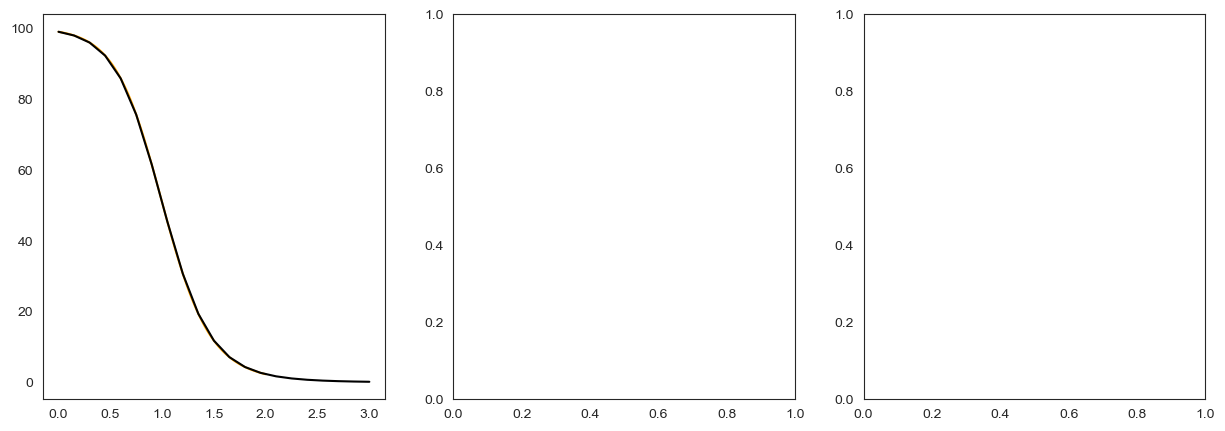

In [152]:
# Plot predicted values for S, I, and R with uncertainty bands
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot predicted susceptible
sns.lineplot(x=time_points, y=S_pred.mean(dim=1), color='orange', ax=ax[0])
sns.lineplot(x=time_period, y=sir_traj.S, color='black', ax=ax[0])
# ax[0].fill_between(time_points, S_pred.mean(dim=1) - 20*S_pred.std(dim=1), S_pred.mean(dim=1) + 20*S_pred.std(dim=1), alpha=0.2, color='orange')

# sns.despine()
# ax[0].set_xlabel("Time (Yrs)")
# ax[0].set_ylabel("# of Individuals (Millions)")
# ax[0].set_title("Predicted # Susceptible")

# # Plot predicted infected
# sns.lineplot(x=time_period, y=I_pred.mean(dim=0), color='red', ax=ax[1])
# ax[1].fill_between(time_period, I_pred.mean(dim=0) - 2*I_pred.std(dim=0), I_pred.mean(dim=0) + 2*I_pred.std(dim=0), alpha=0.2, color='red')
# sns.despine()
# ax[1].set_xlabel("Time (Yrs)")
# ax[1].set_ylabel("# of Individuals (Millions)")
# ax[1].set_title("Predicted # Infected")

# # Plot predicted recovered
# sns.lineplot(x=time_period, y=R_pred.mean(dim=0), color='green', ax=ax[2])
# ax[2].fill_between(time_period, R_pred.mean(dim=0) - 2*R_pred.std(dim=0), R_pred.mean(dim=0) + 2*R_pred.std(dim=0), alpha=0.2, color='green')
# sns.despine()
# ax[2].set_xlabel("Time (Yrs)")
# ax[2].set_ylabel("# of Individuals (Millions)")
# ax[2].set_title("Predicted # Recovered")

# # Plot observed values for S, I, and R
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# # Plot observed susceptible
# sns.lineplot(x=obs_time_period, y=S_obs, color='orange', ax=ax[0])
# sns.despine()

# # Plot observed infected
# sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
# sns.despine()

# # Plot observed recovered
# sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
# sns.despine()


In [38]:
# Multilevel SIR modeling
# Generate different states for a number of different countries
# Each country conditional on covariates has same dynamics

# Some countries enact different policies at different times
# pool all information together to estimate dynamics

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan